# Supplementary Material 1. Local sensitivity analysis

Based on traditional metabolic control theory, we computed local sensitivity indices $Z_i$ to monitor the changes in the output variable, i.e. growth rate, when every single input variable, i.e. each gene dosage, is altered. However, local sensitivity analysis does not explore the entire parameter space and is unable to isolate the effect of (non-linear) variable interactions.

However, before computing local sensitivity analysis, we would like to generate the dosage-response curves of all genes in many genetic backgrounds, to get a sense of "how" metabolism works.


## 0. Load plotting style and...

In [1]:
from matplotlib import pyplot as plt

SMALL_SIZE =  16 # 16 -> around 7pts (real Res&Size)
MEDIUM_SIZE = 20 # 20 -> around 9pts (real Res&Size)
colors = plt.style.library['seaborn-deep']['axes.prop_cycle'].by_key()['color']

# Set plot style
if 'styleDefault' not in locals():
    styleDefault = plt.rcParams.copy()
    
styleDict    = plt.style.library['seaborn-deep']
styleDict.update( { 'figure.dpi'       : 100.0        })
styleDict.update( { 'figure.facecolor' : (1,1,1,1)    })
styleDict.update( { 'axes.labelsize'   : MEDIUM_SIZE  })
styleDict.update( { 'font.size'        : SMALL_SIZE   })
styleDict.update( { 'axes.titlesize'   : SMALL_SIZE   })
styleDict.update( { 'xtick.labelsize'  : SMALL_SIZE   })
styleDict.update( { 'ytick.labelsize'  : SMALL_SIZE   })
styleDict.update( { 'legend.fontsize'  : SMALL_SIZE   })

for key, value in styleDict.items():
    plt.rcParams[key] = value

## ... load model, bounds and...

In [2]:
import cobra
import numpy as np
from tqdm import tqdm
from datetime import datetime
from multiprocessing import Pool
from matplotlib import pyplot as plt
from QuantitativeMutation import QuantitativeMutation


#Define conversion functions
rxn2mtb  = lambda REACTION:   [mtb for mtb in REACTION.metabolites ]
rxn2gene = lambda REACTION:   [gene for gene in REACTION.genes ]
mtb2rxn  = lambda METABOLITE: [rxn for rxn in METABOLITE.reactions ]
gene2rxn = lambda GENE:       [rxn for rxn in GENE.reactions]


MODEL_NAME  = 'yeast_iND750'
SOLVER_NAME = 'glpk'


#Define minimal medium...
minimal_medium = {}        
minimal_medium.update( {'EX_o2_e' :     2 }) #... oxygen
minimal_medium.update( {'EX_h2o_e' : 9999 }) #... water
minimal_medium.update( {'EX_co2_e' : 9999 }) #... carbon dioxyde
minimal_medium.update( {'EX_nh4_e' : 9999 }) #... ammonia
minimal_medium.update( {'EX_pi_e'  : 9999 }) #... phosphate
minimal_medium.update( {'EX_so4_e' : 9999 }) #... sulphate
minimal_medium.update( {'EX_k_e'   : 9999 }) #... potassium
minimal_medium.update( {'EX_na1_e' : 9999 }) #... sodium

#... and standard medium
std_medium = minimal_medium.copy()
std_medium.update( {  'EX_glc__D_e' : 20 } )


# Load specific metabolic model...
Q = QuantitativeMutation( './metabolic_models/%s.json' % MODEL_NAME , verbose=True)

#... set solver
Q.model.solver = SOLVER_NAME

#... and standard medium
Q.model.medium = std_medium

#... and load maximal bounds
Q.load_bounds('Data_1_bounds_0.10.csv')
Q.reset_dosage()
Q.apply_dosage()

#Compute solution
wt_solution  = Q.optimize()
wt_growthrate= Q.slim_optimize()
print('\nWild-type growth rate %1.3f' % Q.slim_optimize() )

Academic license - for non-commercial use only - expires 2022-08-06
Using license file /home/pyubero/gurobi.lic
Loaded model iND750 from user file.
Biomass reaction id is BIOMASS_SC4_bal
The model has 750 genes and 1266 reactions.
... number of exchange reactions:	116
... number of non-exchange reactions:	1148
Maxbounds loaded from Data_1_bounds_0.10.csv on 2022-05-15 12:25:22.564360.

Wild-type growth rate 0.514


## ... PGS data.

In [3]:
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


data = np.load('Data_2_PPS_def_std.npz')
G_std    = data['G_std']  #... Genotype
f_std    = data['f_std']  #... FBA fitness
J_std    = data['J_std']  #... FBA solution fluxes
coef_std = data['B_std']  #... Effect size
R2_std  = data['R2_std'] #... PPS R2

NSAMPLES = G_std.shape[0]
NGENES   = G_std.shape[1]
NFLUXES  = J_std.shape[1]

print('Data laoded.')
print('# samples:\t%d' % NSAMPLES )
print('# genes:  \t%d' % Q.N_GENES )
print('R2 of PPS: \t%1.4f' % R2_std )


B_THRESHOLD =0.01 

#... find genes with large/small effect
large = np.argwhere(  B_THRESHOLD < np.abs(coef_std) )[:,0]
small = np.argwhere(  [ 0<np.abs(value)<B_THRESHOLD for value in coef_std] )[:,0]

#... sort the genes with descending effect size
large_ord = coef_std[large].argsort()[::-1]
small_ord = coef_std[small].argsort()[::-1]

#... concatenate both sets of large and small
values  = np.concatenate( (coef_std[large[large_ord]],coef_std[small[small_ord]]) )
indices = np.concatenate( (large[large_ord], small[small_ord]) )
labels=[ Q.model.genes[idx].name for idx in indices ]

print('N_total   = %d' % len(values) )
print('  N_large = %d' % len(large) )
print('  N_small = %d' % len(small) )
print('  N_null = %d' % (Q.N_GENES-len(large)-len(small) ) )

Data laoded.
# samples:	5000
# genes:  	750
R2 of PPS: 	0.2694
N_total   = 82
  N_large = 32
  N_small = 50
  N_null = 668


## 1a. Generate dosage-response profiles across population
We measure sensitivity by changing the gene dosage of each gene in each background. In this way we obtain the profiles $\mu=\mu ( g_i | \vec g_j)$ where $\mu$ is the growth rate or biomass production, $\vec g_j$ is the background genotype and $g_i$ is the i-eth gene's dosage. Therefore we can plot all the dosage-response profiles of all genes and of all backgrounds to check how their gene dosage affects growth rate.


## 1b. Load data

In [4]:
FILENAME = 'Data_S1_dosage_response_profiles.npz'


data = np.load(FILENAME)
M = data['S'] 
dosage_array = data['dosage']

print('Data loaded!')
print('Shape of M: ', M.shape )

Data loaded!
Shape of M:  (200, 750, 11)


### Plot the dosage-response profile of an example gene

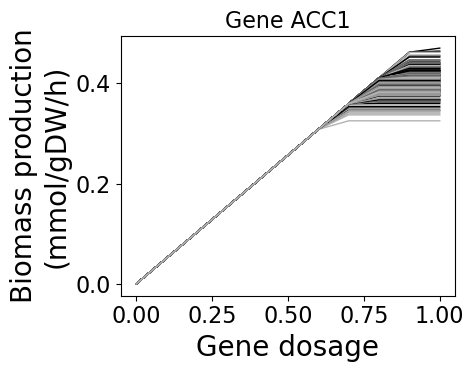

In [5]:
idx = 208

plt.figure( figsize=(5,4))
with plt.style.context('grayscale'):
    plt.plot(dosage_array , M[:,idx,:].T ,'-', ms=4, lw=1);
plt.xlabel('Gene dosage')
plt.ylabel('Biomass production\n(mmol/gDW/h)')
plt.title('Gene %s' % Q.model.genes.get_by_id(Q.GENES[idx]).name )
plt.tight_layout();

### [plot] Profiles of all, large and small effect, predictors

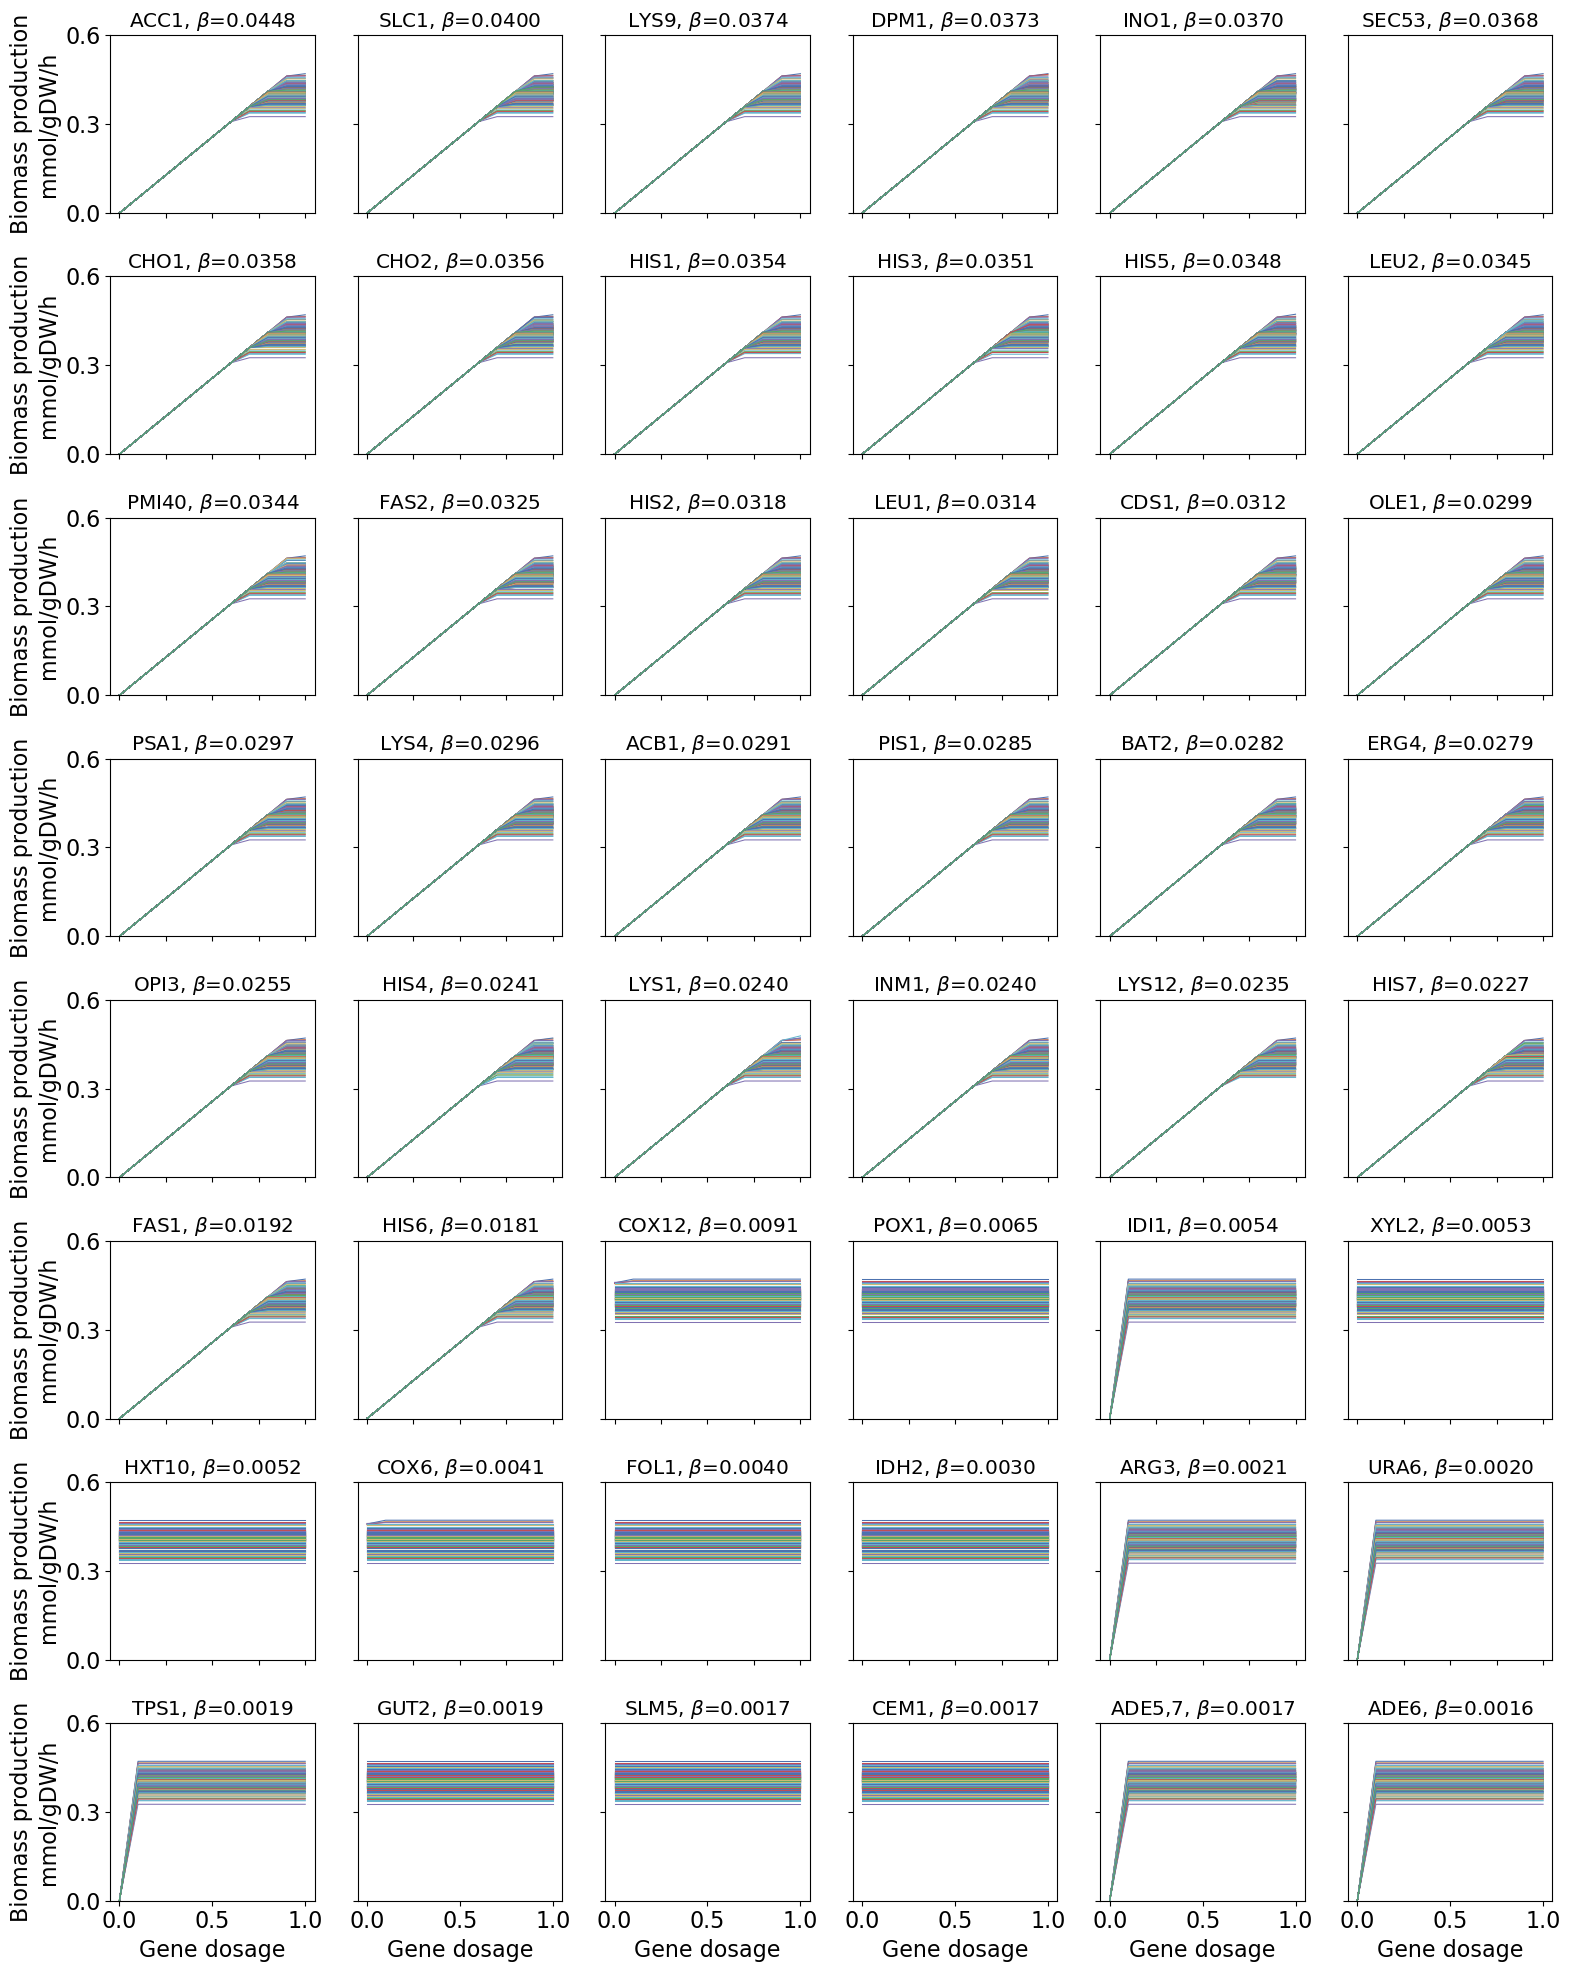

In [6]:
NCOLS = 6
NROWS = 8

ymin, ymax = 0.0 , 0.6

plt.figure(figsize=(16,20))

nplot = 0

# Uncomment this line, and comment the next to plot
# ... the profiles of a random selection of genes
# for ig in np.random.permutation( [ jj for jj in range(Q.N_GENES) if jj not in indices] ): 
for ig in indices:

    nplot += 1
    plt.subplot( NROWS , NCOLS , nplot)
    plt.plot(dosage_array, M[:,ig,:].T , lw=0.75);
    plt.title( r'%s, $\beta$=%1.4f' % (Q.model.genes[ig].name , coef_std[ig] ), fontsize=0.9*SMALL_SIZE )
    plt.ylim(ymin, ymax)
    plt.yticks( np.linspace(ymin,ymax,3), labels='')
    plt.xticks( np.linspace(0,1,5), labels='')
    
    if np.mod(nplot, NCOLS)==1:
        plt.yticks( np.linspace(ymin,ymax,3) , labels=np.linspace(ymin,ymax,3)  )
        plt.ylabel('Biomass production\nmmol/gDW/h', fontsize=SMALL_SIZE)
    
    if nplot> (NCOLS*(NROWS-1)):
        plt.xticks( np.linspace(0,1,3), labels=np.linspace(0,1,3) )
        plt.xlabel('Gene dosage', fontsize=SMALL_SIZE)
    
    if nplot==(NCOLS*NROWS):
        break
        
plt.tight_layout();

## 2a. Metabolic control parameter, or sensitivity matrix $Z_{ij}$, generate data

Following [Kacser1981](link) we can measure the expected local sensitivity index of the j-eth flux wrt the i-eth enzyme across the N genetic backgrounds (population samples) :

$Z_{ij} =\Delta\ln(f_j) / \Delta\ln(g_i)$

#### For a single individual

#### In parallel

## 2b. Load data to compute Kacser's $Z_{ij}$

In [7]:
FILENAME_Z = 'Data_S1_control_parameterZ.npz'

data = np.load(FILENAME_Z)

Z   = data['Z']
Zmu = Z[:,:,0]
mZmu= np.mean(Zmu, axis=0)
idx = np.argwhere( mZmu>1e-2 )[:,0]


### [plot] Plot

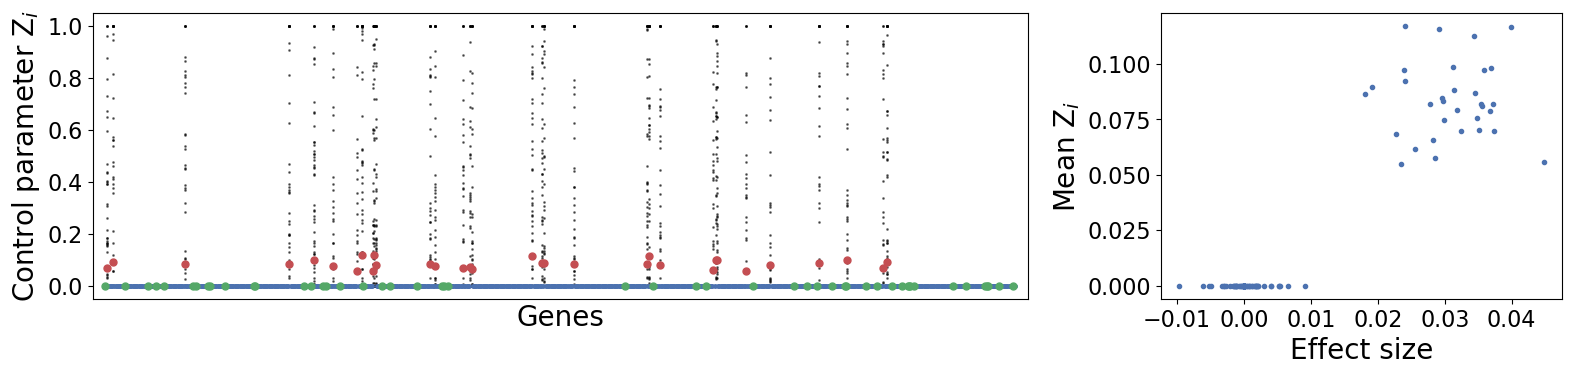

In [8]:
plt.figure( figsize=(16,4))

plt.subplot(1,3,(1,2))
plt.plot(range(Q.N_GENES), Zmu.T,'k.', alpha=0.5, ms=2);
plt.plot(range(Q.N_GENES), mZmu, '.', ms=5)
plt.plot(small, mZmu[small],'.', ms=10)
plt.plot(large, mZmu[large],'.', ms=10)
plt.xticks(ticks=(), labels='')
plt.xlabel('Genes')
plt.ylabel('Control parameter Z$_i$')
plt.xlim(-10,760)

plt.subplot(1,3,3)
plt.plot(coef_std, np.nanmean(Zmu, axis=0),'.')
plt.xlabel('Effect size')
plt.ylabel('Mean Z$_i$')
yticks= plt.yticks()[0][1:-1]



plt.tight_layout();

